This is nothing but a copy of original ``pol_analyze.ipynb`` during the revision phase, to check if the fitting paramters are robust against different functinal form. We tested many, but only provide this linear-exponential function for reader's information. Please see the original ``pol_analyze.ipynb`` file for explanations.

In [1]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'     

In [2]:
import pymc3 as pm

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.math import sin, cos, exp
import theano
import corner

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import ysvisutilpy2005ud as yvu

from scipy.optimize import curve_fit
from scipy.stats import chi2
import polutil2005ud as util

np.random.seed(12345)
plt.style.use('default')
rcParams.update({'font.size':12})
errbfmt = dict(marker='x', capsize=3, elinewidth=0.5, ls='')




### 3-2. Define
The definitions of the functions and some global paramters are in ``poltuil2005ud.py`` file.

In [4]:
D2R = util.D2R
DATAPATH = util.DATAPATH
SAVEPATH = util.SAVEPATH
alpha = util.alpha
polr = util.polr
dpolr = util.dpolr
alpha_msi = util.alpha_msi
polr_msi = util.polr_msi
dpolr_msi = util.dpolr_msi
alpha_oth = util.alpha_oth
polr_oth = util.polr_oth
dpolr_oth = util.dpolr_oth

fitfunc = util.linexp
dofunc = util.do_linexp
fmin = util.linexp_min
fmax = util.linexp_max
n_param = 3
pars = util.pars["linexp"]
p0 = util.p0["linexp"]  
bounds = util.bounds["linexp"]  
cfit_kw = dict(p0=p0, bounds=bounds, absolute_sigma=True)

# Find the least-squares solution
popt, pcov = curve_fit(fitfunc, alpha, polr, sigma=dpolr, **cfit_kw)

xx = np.arange(0.1, 180, 0.1)

In [5]:
dats = util.dats  # see the source code file for the details
dats

,date,alpha,P,dP,theta_P,dtheta_P,Pr,dPr,theta_r,obs
0,2018 Oct 12,0.74,0.39,0.09,NaN,7.05,-0.33,0.09,104.65,ALFOSC/FAPOL
1,2018 Oct 14,2.25,0.87,0.11,NaN,3.80,-0.70,0.11,106.74,ALFOSC/FAPOL
2,2018 Oct 11,2.58,0.51,0.08,NaN,3.77,-0.64,0.08,87.32,ALFOSC/FAPOL
3,2018 Oct 15,4.18,1.10,0.09,NaN,2.81,-0.93,0.09,91.43,ALFOSC/FAPOL
4,2018 Oct 17,7.83,1.09,0.12,NaN,3.50,-1.00,0.12,84.28,ALFOSC/FAPOL
...,...,...,...,...,...,...,...,...,...,...
18,2018 Sep 27,55.44,14.10,1.29,-0.80,2.63,14.09,1.29,0.65,MSI
19,2018 Sep 25,63.60,19.45,0.84,-4.02,1.24,19.33,0.84,-3.18,MSI
20,2018 Sep 24,68.08,22.74,3.59,0.33,4.52,22.73,3.59,0.91,MSI
21,2018 Sep 19,87.74,43.18,0.59,NaN,0.39,43.16,0.59,-0.76,ALFOSC/FAPOL


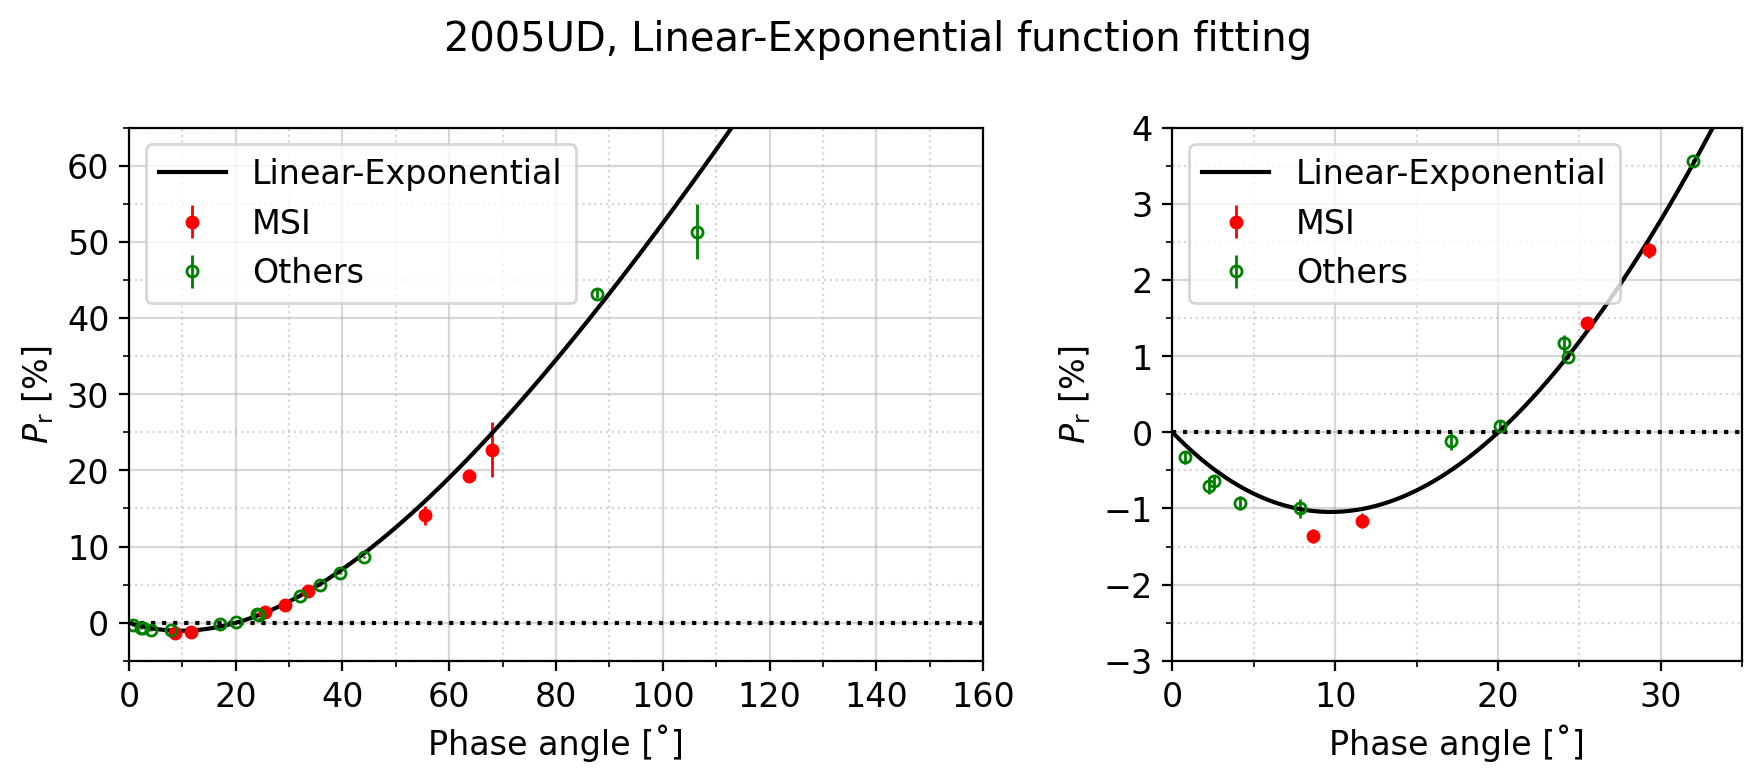

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=False, sharey=False, gridspec_kw=dict(width_ratios=[3, 2]))
util.plot_data(axs)
for ax in axs.flat:
    ax.plot(xx, fitfunc(xx, *popt), 'k-', label="Linear-Exponential")
    ax.legend(loc=2)

fig.suptitle("2005UD, Linear-Exponential function fitting")
fig.tight_layout()

plt.savefig(SAVEPATH / "observation-fit-linexp.png")
plt.savefig(SAVEPATH / "observation-fit-linexp.pdf")

Simple least-square fit will give the following best-fit parameters with the diagonal components as the variance of parameters when the $\chi^2$ contour are N-D ellipse (which is not used for error analysis):

In [7]:
print("Least Square fit & elliptical approximation errors with Scipy curve_fit\n")

amin, Pmin = fmin(np.arange(0, 20, 0.01), *popt)
amax, Pmax = fmax(np.arange(80, 170, 0.01), *popt)

for model, popt, pcov in zip(["Linear-Exponential"], [popt], [pcov]):
    amin, Pmin = fmin(np.arange(0, 20, 0.01), *popt)
    amax, Pmax = fmax(np.arange(80, 170, 0.01), *popt)
    print(f"{model} case")
    print(" h[%/˚]  a0[˚]     k        amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
    print(f" {popt[0]:.4f}  {popt[1]:.4f}   {popt[2]:.4f}   {amin:.2f}     {Pmin:.2f}    {amax:.2f}  {Pmax:.2f}")
    print("±{:.4f}  ±{:.4f}  ±{:.4f}\n".format(*np.sqrt(np.diag(pcov))))

Least Square fit & elliptical approximation errors with Scipy curve_fit

Linear-Exponential case
 h[%/˚]  a0[˚]     k        amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
 0.1969  20.0208   0.0176   9.72     -1.05    169.98  125.87
±0.0041  ±0.1349  ±0.0012



In [8]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', pars['h'].low, pars['h'].upp)
    a0 = pm.Uniform('a0', pars['a0'].low, pars['a0'].upp)
    k = pm.Uniform('k', pars['k'].low, pars['k'].upp)

    sigma = theano.shared(np.asarray(dpolr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h
             * (alpha - a0*(1 - (1 + k*alpha*exp(-k*(a0-alpha)))*exp(-k*alpha))/(1 - (1 + k*a0)*exp(-k*a0)))
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=polr)
    start = {}
    for name, par in pars.items():
        start[name] = par.p0
    trace = pm.sample(20000, start=dict(h=0.1, a0=20, k=1))

/var/folders/h6/tz6c2ch9771g23446ncvbczw0000gn/T/ipykernel_25002/23137902.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(20000, start=dict(h=0.1, a0=20, k=1))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, a0, h]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8994621703282268, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883989262105843, but should be close to 0.8. Try to increase the number of tuning steps.


/var/folders/h6/tz6c2ch9771g23446ncvbczw0000gn/T/ipykernel_25002/2597920336.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/Users/ysbach/opt/anaconda3/envs/2005ud/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


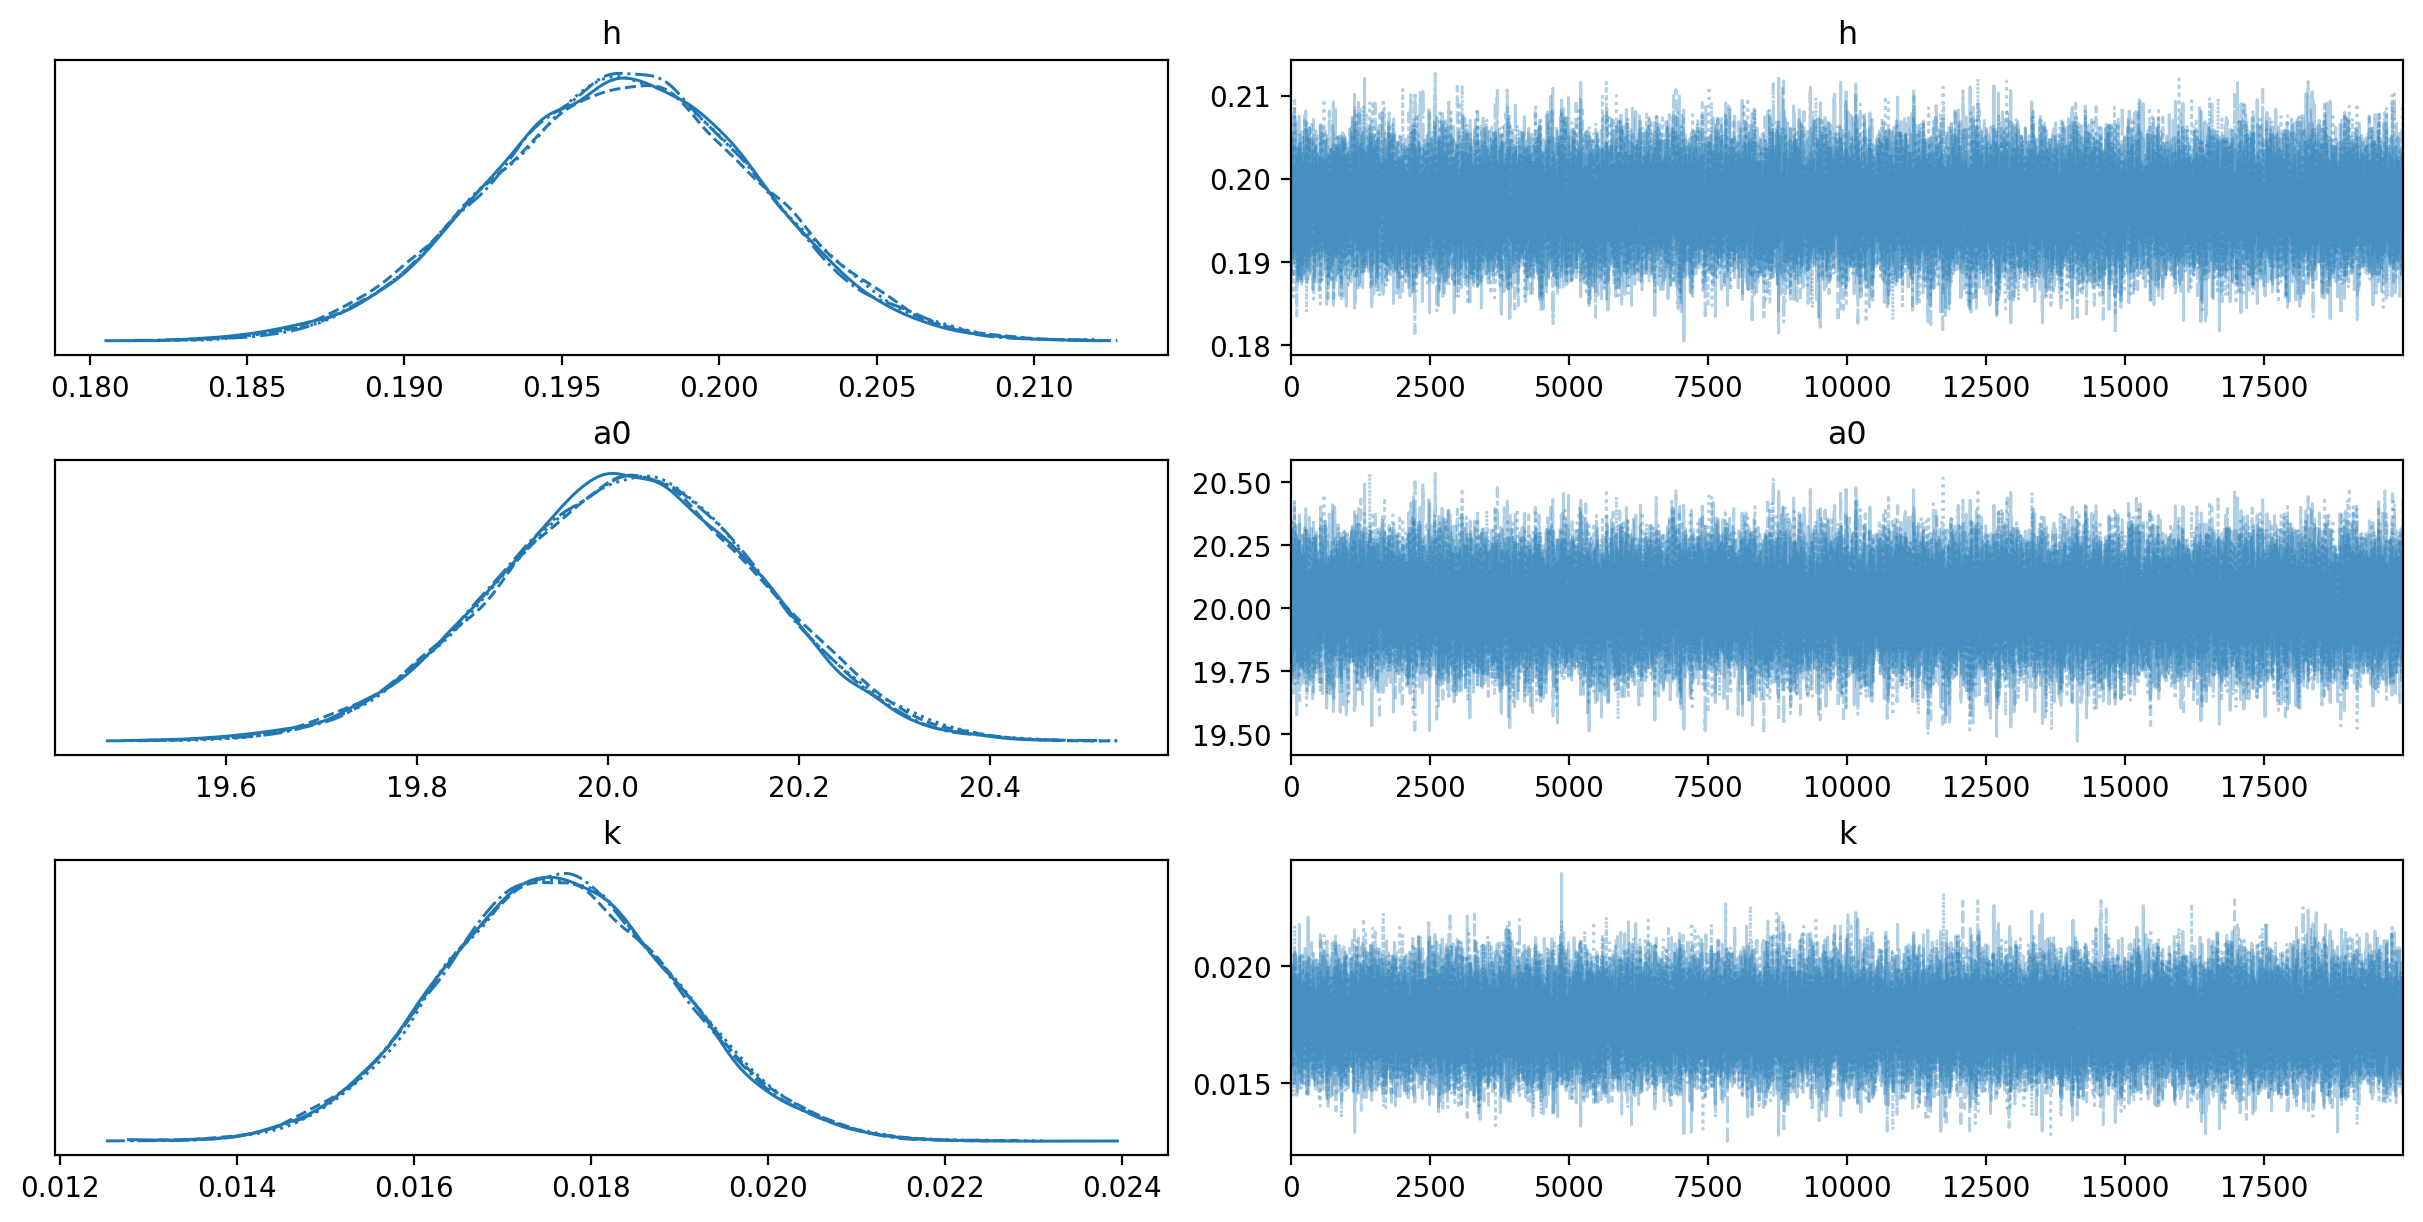

In [9]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "trace-linexp.png", dpi=300)
plt.savefig(SAVEPATH / "trace-linexp.pdf")

In [10]:
pm.summary(trace, hdi_prob=0.6827).round(5)

/Users/ysbach/opt/anaconda3/envs/2005ud/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_15.865%,hdi_84.135%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.197,0.004,0.193,0.201,0.000,0.000,21340.0,26111.0,1.0
a0,20.019,0.138,19.886,20.163,0.001,0.001,23197.0,28958.0,1.0
k,0.018,0.001,0.016,0.019,0.000,0.000,25618.0,31258.0,1.0


In [11]:
# Merge all the samples from the MCMC into a numpy ndarray:
samples = np.array([trace.get_values(k) for k in pars.keys()]).T

# Do Chi-2 analysis
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], k=trace['k'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

dofunc(
    alpha, polr, dpolr,
    arr_h=res["h"], arr_a0=res["a0"], arr_k=res["k"],
    arr_chi2=res["chi2"], arr_amax=res["amax"], arr_Pmax=res["Pmax"], arr_amin=res["amin"], arr_Pmin=res["Pmin"]
)

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-n_param)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

The min/max of ``res_1sig_b`` for each column (parameters) will be 1-sigma bounds of them (summarized below). Those of ``res_df_b`` gives the 1-σ bounds for α_min/max and P_min/max.

Summarize:

In [12]:
param_tab = dict(pars=list(pars.keys()) + ["amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

,pars,lsqs,plus,minus,mins,maxs
0,h,0.196915,0.007815,0.007891,0.189024,0.204730
1,a0,20.020769,0.249643,0.261694,19.759075,20.270412
2,k,0.017581,0.002472,0.002370,0.015211,0.020053
3,amin,9.717058,0.100365,0.106314,9.610744,9.817423
4,Pmin,-1.045090,0.060975,0.061629,-1.106719,-0.984115
5,amax,169.980000,30.000000,30.000000,139.980000,139.980000
6,Pmax,125.871182,28.716997,36.778977,89.092205,97.154186


### 4-5. Pairplot of Parameters

Draw a corner plot

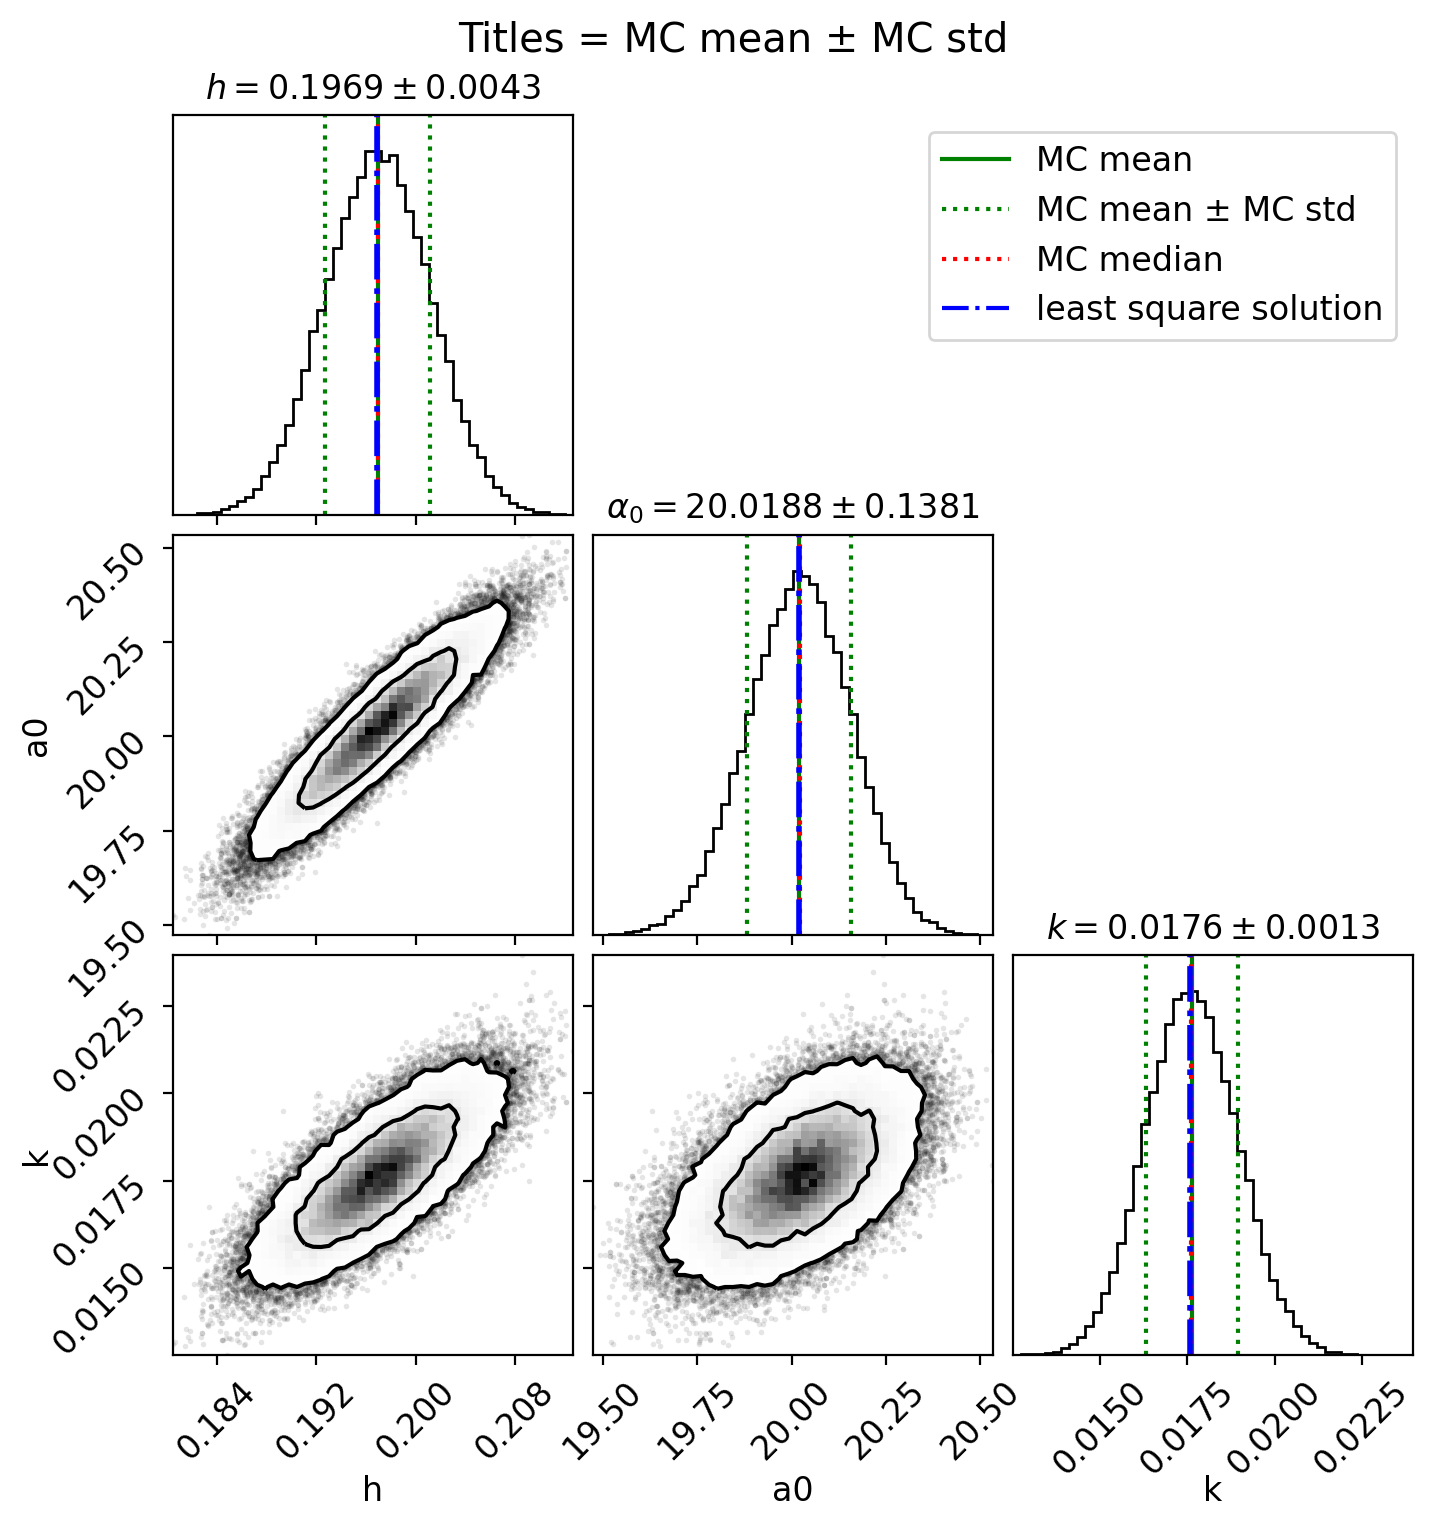

In [13]:
trace_df = pm.trace_to_dataframe(trace)
means = np.mean(trace_df, axis=0)
meds = np.median(trace_df, axis=0)
sds = np.std(trace_df, axis=0, ddof=1)
varnames = dict(h='h', a0='\\alpha_0', k='k')

fig = corner.corner(
    trace_df, 
#     quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
    levels=[0.6827, 0.9545], #, 0.9973
    bins=50,
    show_titles=False,
    title_fmt='5.3f',
    title_kwargs={'fontsize': 12}
)
axes = np.array(fig.axes).reshape((n_param, n_param))

# Loop over the diagonal
for i in range(n_param):
    ax = axes[i, i]
    ax.axvline(means[i], color="g", ls='-')
    ax.axvline(means[i] - sds[i], color="g", ls=':')
    ax.axvline(means[i] + sds[i], color="g", ls=':')
    ax.axvline(meds[i], color="r", ls=':')
    ax.axvline(popt[i], color='b', ls='-.', lw=2)
    ax.set_title(r"${} = {:4.4f} \pm {:4.4f}$".format(varnames[trace.varnames[n_param+i]],
                                                     means[i],
                                                     sds[i]
                                                    ),
                fontsize=12)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'g:', label='MC mean ± MC std')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
# axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC mean ± MC std", y=1.01)
plt.savefig(SAVEPATH/"corner-linexp.pdf")
plt.savefig(SAVEPATH/"corner-linexp.png", dpi=300);

In [14]:
for k in ["amin", "Pmin", "amax", "Pmax"]:
    means[k] = res_1sig[k].mean()
    sds[k] = res_1sig[k].std()

# Combined PPC (Both bound and unbound)

In [15]:
vals = [fitfunc(xx, *sample) for sample in samples]
mins = np.min(vals, axis=0)
maxs = np.max(vals, axis=0)

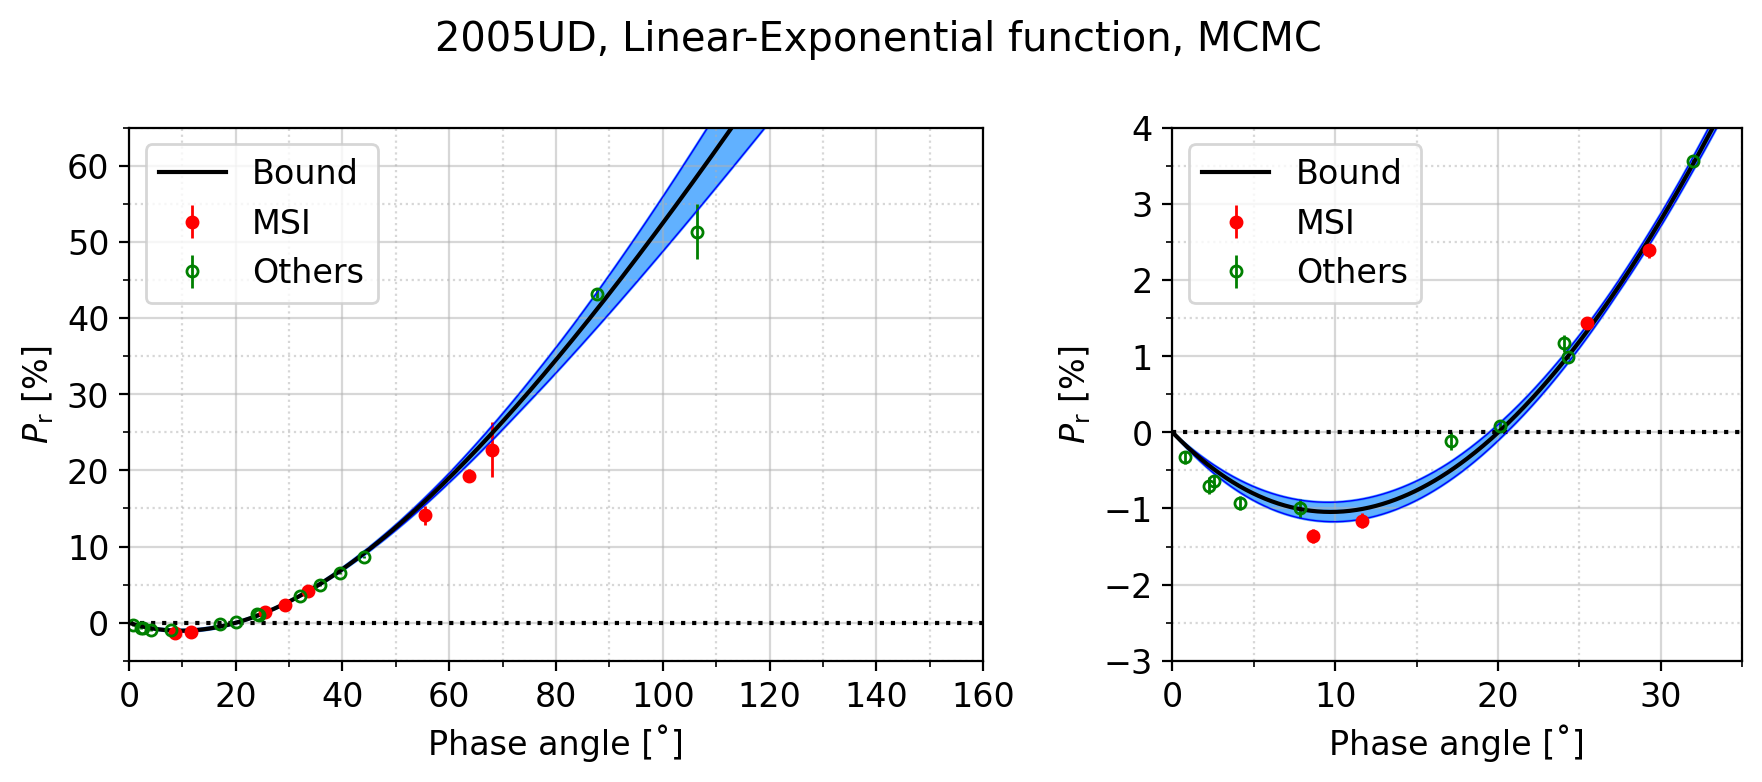

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=False, sharey=False, gridspec_kw=dict(width_ratios=[3, 2]))
util.plot_data(axs)
for ax in axs.flat:
    ax.fill_between(xx, mins, maxs, color='dodgerblue', alpha=0.7)
    ax.plot(xx, mins, color='b', lw=0.5)
    ax.plot(xx, maxs, color='b', lw=0.5)
    ax.plot(xx, fitfunc(xx, *popt), 'k-', label="Bound")
    ax.legend(loc=2)

plt.suptitle("2005UD, Linear-Exponential function, MCMC")

plt.tight_layout()
plt.savefig(SAVEPATH / "observation-mcmc-comb-linexp.png", dpi=300)
plt.savefig(SAVEPATH / "observation-mcmc-comb-linexp.pdf")

In [17]:
print(means)
for m, s in zip(means, sds):
    print("{:.4f} ± {:.4f}".format(m, s))

h         0.196947
a0       20.018828
k         0.017627
amin      9.716030
Pmin     -1.045380
amax    139.980000
Pmax     93.005201
dtype: float64
0.1969 ± 0.0043
20.0188 ± 0.1381
0.0176 ± 0.0013
9.7160 ± 0.0419
-1.0454 ± 0.0246
139.9800 ± 0.0000
93.0052 ± 1.6312


In [18]:
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was finished at {now} ")

NameError: name 'time' is not defined